# Grover's algorithm


*Estimated QPU usage: 4 seconds (tested on IBM Nairobi)*

## Background

Amplitude amplification is a general purpose quantum algorithm, or subroutine, that can be used to obtain a quadratic speedup over a handful of classical algorithms. [Grover’s algorithm](https://arxiv.org/abs/quant-ph/9605043) was the first to demonstrate this speedup on unstructured search problems. Formulating a Grover's search problem requires an oracle function that marks one or more computational basis states as the states we are interested in finding, and an amplification circuit that increases the amplitude of marked states, consequently suppressing the remaining states.

Here, we demonstrate how to construct Grover oracles and use the `GroverOperator` from the Qiskit circuit library to easily set up a Grover's search instance. The runtime `Sampler` primitive allows seamless execution of Grover circuits.


## Requirements

Before starting this tutorial, ensure that you have the following installed:

* Qiskit SDK 1.0 or later, with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime (`pip install qiskit-ibm-runtime`) 0.22 or later


## Step 1. Map classical inputs to a quantum problem

Grover's algorithm requires an [oracle](https://learning.quantum-computing.ibm.com/course/fundamentals-of-quantum-algorithms/grovers-algorithm) that specifies one or more marked computational basis states, where "marked" means a state with a phase of -1.  A controlled-Z gate, or its multi-controlled generalization over $N$ qubits, marks the $2^{N}-1$ state (`'1'`\*$N$ bit-string).  Marking basis states with one or more `'0'` in the binary representation requires applying X-gates on the corresponding qubits before and after the controlled-Z gate; equivalent to having an open-control on that qubit.  In the following code, we define an oracle that does just that, marking one or more input basis states defined through their bit-string representation.  The `MCMT` gate is used to implement the multi-controlled Z-gate.


### Setup

Here we import the small number of tools we need for this tutorial.


In [1]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Local simulator sampler (no IBM Quantum hardware needed)
from qiskit.primitives import StatevectorSampler

# For visualization
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
        qc.barrier()
    return qc

### Specific Grover's instance

Now that we have the oracle function, we can define a specific instance of Grover search.  In this example we will mark two computational states out of the thirty-two available in a five-qubit computational space:


In [5]:
!pip install pylatexenc

  Using cached pylatexenc-2.10-py3-none-any.whl



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\2505002\AppData\Local\Temp\ipykernel_38908\3770229416.py:27: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.mcmt.MCMT`` is deprecated as of Qiskit 1.4. It will be removed no earlier than 3 months after the release date. Use MCMTGate instead.
  qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)


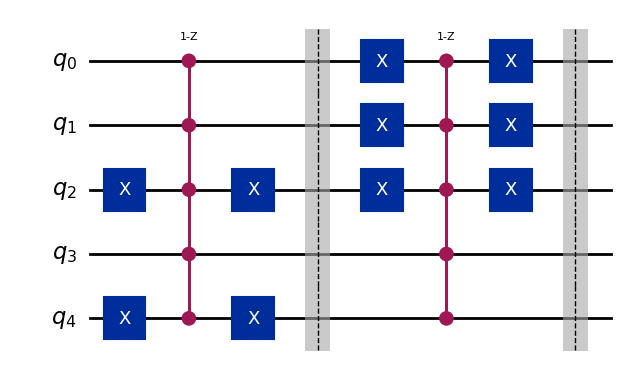

In [3]:
marked_states = ["01011", "11000"]
# 일반적으로 찾고싶은 솔루션이 여러개일 수도 있으니, 두개를 달면 뭐 둘 다 뒤집어준다.
oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

# 0이 X고, q4가 제일 먼저 오는 것 (5 qubits now)

### GroverOperator

The built-in Qiskit `GroverOperator` takes an oracle circuit and returns a circuit that is composed of the oracle circuit itself and a circuit that amplifies the states marked by the oracle.  Here, we `decompose` the circuit to see the gates within the operator:


C:\Users\2505002\AppData\Local\Temp\ipykernel_38908\771587572.py:1: DeprecationWarning: The class ``qiskit.circuit.library.grover_operator.GroverOperator`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use qiskit.circuit.library.grover_operator instead.
  grover_op = GroverOperator(oracle)


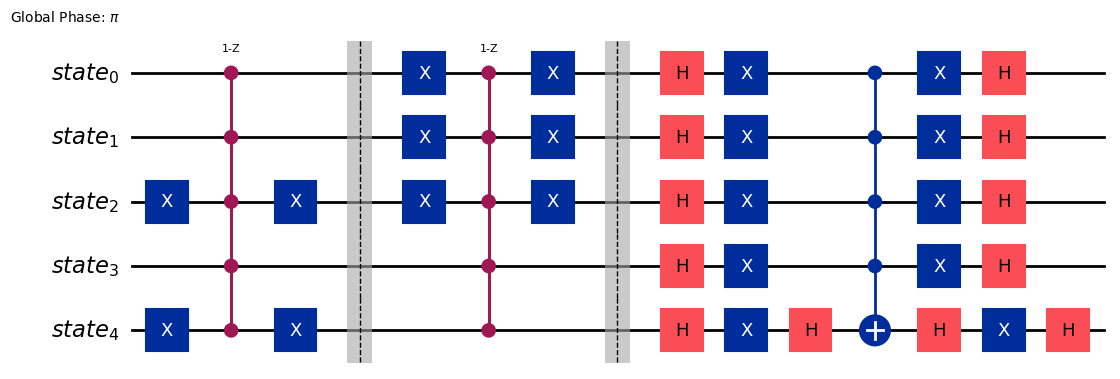

In [4]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

#빨간 부분 (오른쪽 두개)가 리플렉션을 구현한다.

Repeated applications of this `grover_op` circuit amplify the marked states, making them the most probable bit-strings in the output distribution from the circuit.  There is an optimal number of such applications that is determined by the ratio of marked states to total number of possible computational states:


In [5]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

In [6]:
optimal_num_iterations

3

### Geometric Visualization — How the "Flip and Turn" Works

Grover's algorithm can be understood geometrically as rotations in a 2D plane spanned by two orthogonal vectors:

- **|w⟩** — the normalized superposition of *marked* (target) states
- **|s'⟩** — the normalized superposition of *unmarked* states

The initial uniform superposition |s⟩ makes a small angle θ₀ = arcsin(√(M/N)) with the |s'⟩ axis. Each Grover iteration consists of **two reflections**:

1. **Oracle (flip)** — reflects the state about the |s'⟩ axis, negating the |w⟩ component. The vector "flips" into the lower half-plane.
2. **Diffusion (rotate)** — reflects the state about the original |s⟩ direction, swinging it back up and *past* where it started.

The combined effect is a net rotation by **2θ₀** toward |w⟩ per iteration. After *k* iterations the angle is (2k+1)θ₀. When it approaches 90°, nearly all the probability is on the marked states.

Below we simulate each half-step and visualize the trajectory on the unit circle.


  Grover's on 5 qubits  ·  N = 32  ·  M = 2  ·  θ₀ = 14.48°
  Optimal iterations: 3

  Step                                    Angle   P(marked)
  ─────────────────────────────────────────────────────────
  Initial |s⟩                            +14.48°      0.0625
  Iter 1: Oracle (flip)                  -14.48°      0.0625
  Iter 1: Diffusion (rotate)             +43.43°      0.4727
  Iter 2: Oracle (flip)                  -43.43°      0.4727
  Iter 2: Diffusion (rotate)             +72.39°      0.9084
  Iter 3: Oracle (flip)                  -72.39°      0.9084
  Iter 3: Diffusion (rotate)            +101.34°      0.9613


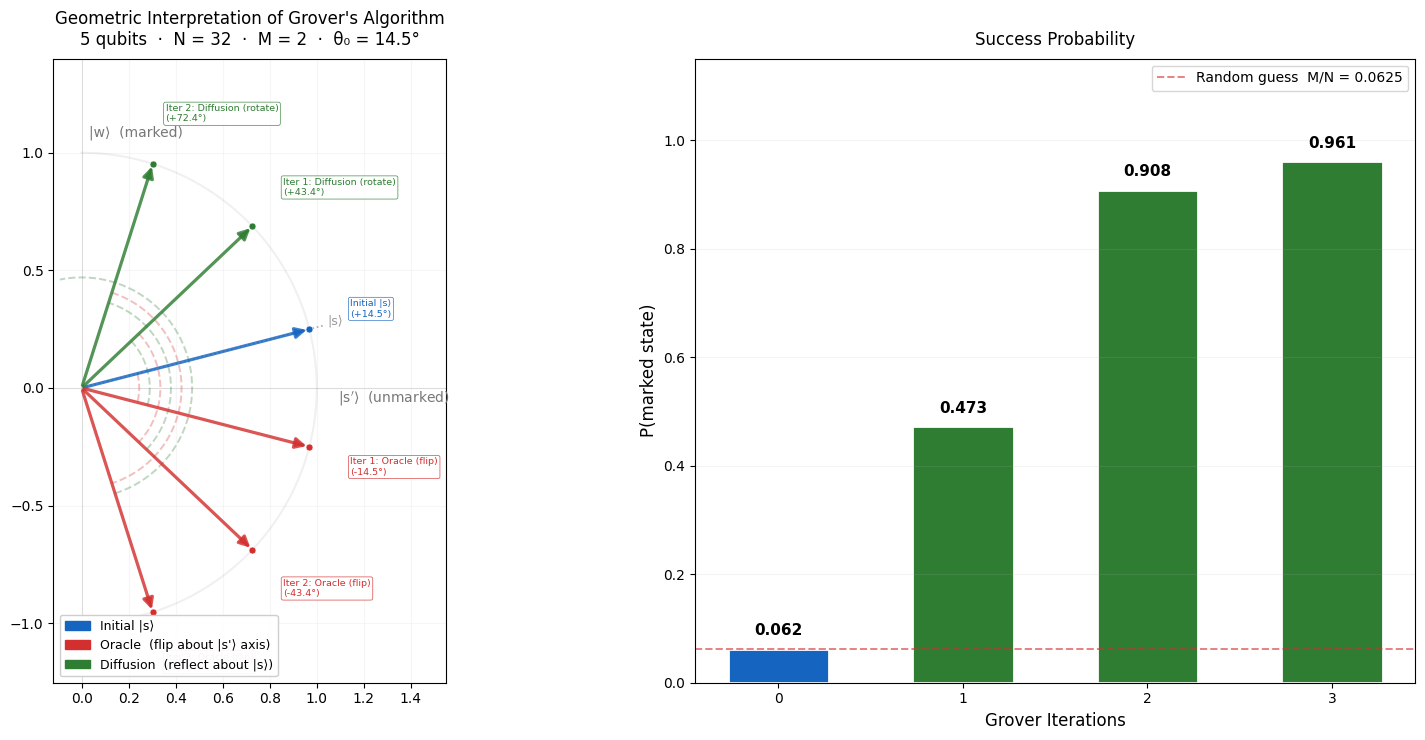

In [8]:
# ══════════════════════════════════════════════════════════════════
# Step-by-step simulation of Grover's algorithm
# ══════════════════════════════════════════════════════════════════

n_q = grover_op.num_qubits
N = 2 ** n_q
M = len(marked_states)
theta_0 = np.arcsin(np.sqrt(M / N))

# Marked-state indices (integer representation)
marked_idx = [int(s, 2) for s in marked_states]

# ── Basis vectors in computational space ──
w_vec = np.zeros(N)                        # |w⟩  – marked subspace
for idx in marked_idx:
    w_vec[idx] = 1.0
w_vec /= np.linalg.norm(w_vec)

s_prime = np.zeros(N)                      # |s'⟩ – unmarked subspace
for i in range(N):
    if i not in marked_idx:
        s_prime[i] = 1.0
s_prime /= np.linalg.norm(s_prime)

s_uniform = np.ones(N) / np.sqrt(N)       # |s⟩  – uniform superposition


def oracle_op(psi):
    """Oracle: negate amplitudes of marked states (reflect about |s'⟩)."""
    out = psi.copy()
    for idx in marked_idx:
        out[idx] *= -1
    return out


def diffusion_op(psi):
    """Diffusion: 2|s⟩⟨s| − I  (reflect about |s⟩)."""
    return 2 * np.vdot(s_uniform, psi) * s_uniform - psi


def to_2d(psi):
    """Project onto the (|s'⟩, |w⟩) plane → (x, y)."""
    return (float(np.real(np.vdot(s_prime, psi))),
            float(np.real(np.vdot(w_vec, psi))))


# ── Run simulation, record every half-step ──
psi = s_uniform.copy()
traj = []   # (label, x, y, kind)

x, y = to_2d(psi)
traj.append(("Initial |s⟩", x, y, "initial"))

for k in range(optimal_num_iterations):
    psi = oracle_op(psi)
    x, y = to_2d(psi)
    traj.append((f"Iter {k+1}: Oracle (flip)", x, y, "oracle"))

    psi = diffusion_op(psi)
    x, y = to_2d(psi)
    traj.append((f"Iter {k+1}: Diffusion (rotate)", x, y, "diffusion"))

# Print summary table
print(f"  Grover's on {n_q} qubits  ·  N = {N}  ·  M = {M}"
      f"  ·  θ₀ = {np.degrees(theta_0):.2f}°")
print(f"  Optimal iterations: {optimal_num_iterations}\n")
print(f"  {'Step':<35s}  {'Angle':>8s}  {'P(marked)':>10s}")
print("  " + "─" * 57)
for lbl, x, y, _ in traj:
    ang = np.degrees(np.arctan2(y, x))
    print(f"  {lbl:<35s}  {ang:>+8.2f}°  {y**2:>10.4f}")


# ══════════════════════════════════════════════════════════════════
# Figure 1 – Geometric view  +  Success probability
# ══════════════════════════════════════════════════════════════════

fig, (ax_geo, ax_bar) = plt.subplots(
    1, 2, figsize=(17, 7.5),
    gridspec_kw={"width_ratios": [1.4, 1]})

# ── Left panel: 2-D state-vector trajectory ──────────────────────

# faint unit-circle arc (upper + lower half visible)
t_arc = np.linspace(-np.pi / 2, np.pi / 2, 400)
ax_geo.plot(np.cos(t_arc), np.sin(t_arc), color="black", alpha=0.06, lw=1.5)

# axes
ax_geo.axhline(0, color="gray", lw=0.4, alpha=0.4)
ax_geo.axvline(0, color="gray", lw=0.4, alpha=0.4)
ax_geo.text(1.09, -0.06, r"|s$'$⟩  (unmarked)", fontsize=10, color="#777")
ax_geo.text(0.03, 1.07, "|w⟩  (marked)", fontsize=10, color="#777")

# |s⟩ reference direction
ax_geo.plot([0, 1.06 * np.cos(theta_0)], [0, 1.06 * np.sin(theta_0)],
            ":", color="#aaa", lw=1.2)
ax_geo.text(1.08 * np.cos(theta_0), 1.08 * np.sin(theta_0),
            "|s⟩", fontsize=9, color="#999")

# Color palette
COL = {"initial": "#1565C0", "oracle": "#D32F2F", "diffusion": "#2E7D32"}

for i, (lbl, x, y, kind) in enumerate(traj):
    c = COL[kind]
    ang_deg = np.degrees(np.arctan2(y, x))

    # arrow from origin
    ax_geo.annotate(
        "", xy=(x, y), xytext=(0, 0),
        arrowprops=dict(arrowstyle="-|>", color=c, lw=2.3,
                        mutation_scale=16, alpha=0.82))
    ax_geo.plot(x, y, "o", color=c, ms=5, zorder=5,
                mec="white", mew=0.4)

    # label placed radially outward from arrow tip
    a = np.arctan2(y, x)
    r_off = 1.18
    lx, ly = r_off * np.cos(a), r_off * np.sin(a)
    ha = "left" if np.cos(a) >= 0 else "right"
    va = "bottom" if np.sin(a) >= 0 else "top"
    ax_geo.annotate(
        f"{lbl}\n({ang_deg:+.1f}°)",
        xy=(lx, ly), fontsize=6.8, color=c, ha=ha, va=va,
        bbox=dict(boxstyle="round,pad=0.2", fc="white",
                  ec=c, alpha=0.88, lw=0.5))

    # connecting arc from previous state
    if i > 0:
        px, py = traj[i - 1][1], traj[i - 1][2]
        a1, a2 = np.arctan2(py, px), np.arctan2(y, x)
        r_arc = 0.20 + 0.045 * i
        ts = np.linspace(a1, a2, 80)
        ax_geo.plot(r_arc * np.cos(ts), r_arc * np.sin(ts),
                    "--", color=c, alpha=0.30, lw=1.4)

# Legend
legend_el = [
    mpatches.Patch(color=COL["initial"],   label="Initial |s⟩"),
    mpatches.Patch(color=COL["oracle"],    label="Oracle  (flip about |s'⟩ axis)"),
    mpatches.Patch(color=COL["diffusion"], label="Diffusion  (reflect about |s⟩)"),
]
ax_geo.legend(handles=legend_el, loc="lower left", fontsize=9, framealpha=0.95)

yy = [t[2] for t in traj]
ax_geo.set_xlim(-0.12, 1.55)
ax_geo.set_ylim(min(min(yy) - 0.3, -0.55), 1.40)
ax_geo.set_aspect("equal")
ax_geo.set_title(
    f"Geometric Interpretation of Grover's Algorithm\n"
    f"{n_q} qubits  ·  N = {N}  ·  M = {M}  ·  "
    f"θ₀ = {np.degrees(theta_0):.1f}°",
    fontsize=12, pad=10)
ax_geo.grid(True, alpha=0.10)

# ── Right panel: P(marked) vs iteration number ──────────────────

iters_x = list(range(optimal_num_iterations + 1))
p_success = [np.sin((2 * k + 1) * theta_0) ** 2 for k in iters_x]

bar_c = ["#1565C0"] + ["#2E7D32"] * optimal_num_iterations
bars = ax_bar.bar(iters_x, p_success, color=bar_c,
                  edgecolor="white", lw=2, width=0.55)

ax_bar.axhline(M / N, color="#D32F2F", ls="--", lw=1.4, alpha=0.6,
               label=f"Random guess  M/N = {M/N:.4f}")

for b, p in zip(bars, p_success):
    ax_bar.text(b.get_x() + b.get_width() / 2, b.get_height() + 0.025,
                f"{p:.3f}", ha="center", fontsize=11, fontweight="bold")

ax_bar.set_xlabel("Grover Iterations", fontsize=12)
ax_bar.set_ylabel("P(marked state)", fontsize=12)
ax_bar.set_title("Success Probability", fontsize=12, pad=10)
ax_bar.set_xticks(iters_x)
ax_bar.set_ylim(0, 1.15)
ax_bar.legend(fontsize=10)
ax_bar.grid(axis="y", alpha=0.15)

plt.tight_layout(w_pad=3)
plt.show()


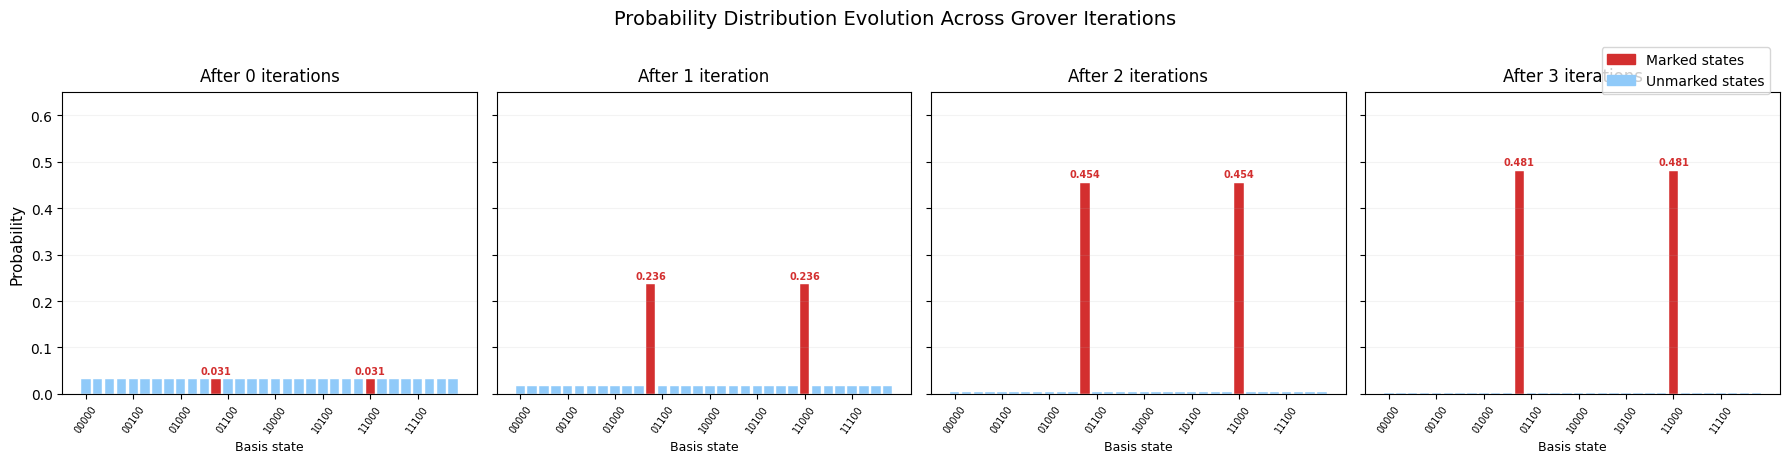

In [9]:
# ══════════════════════════════════════════════════════════════════
# Figure 2 – Full probability distribution at each Grover iteration
# ══════════════════════════════════════════════════════════════════

n_it = optimal_num_iterations
fig2, axes = plt.subplots(1, n_it + 1,
                          figsize=(4.5 * (n_it + 1), 4.5),
                          sharey=True)

psi_snap = s_uniform.copy()
basis_lbl = [format(i, f"0{n_q}b") for i in range(N)]
tick_step = max(1, N // 8)

for k in range(n_it + 1):
    ax = axes[k]
    probs = np.abs(psi_snap) ** 2
    bc = ["#D32F2F" if i in marked_idx else "#90CAF9" for i in range(N)]

    ax.bar(range(N), probs, color=bc, edgecolor="white", lw=0.3)
    ax.set_title(f"After {k} iteration{'s' if k != 1 else ''}",
                 fontsize=12, pad=8)
    ax.set_xlabel("Basis state", fontsize=9)
    if k == 0:
        ax.set_ylabel("Probability", fontsize=11)
    ax.set_xticks(range(0, N, tick_step))
    ax.set_xticklabels([basis_lbl[i] for i in range(0, N, tick_step)],
                       rotation=55, fontsize=7)
    ax.set_ylim(0, 0.65)
    ax.grid(axis="y", alpha=0.15)

    # annotate marked-state probabilities
    for idx in marked_idx:
        if probs[idx] > 0.01:
            ax.text(idx, probs[idx] + 0.012, f"{probs[idx]:.3f}",
                    ha="center", fontsize=7, color="#D32F2F",
                    fontweight="bold")

    if k < n_it:
        psi_snap = oracle_op(psi_snap)
        psi_snap = diffusion_op(psi_snap)

fig2.legend(
    handles=[mpatches.Patch(color="#D32F2F", label="Marked states"),
             mpatches.Patch(color="#90CAF9", label="Unmarked states")],
    loc="upper right", fontsize=10,
    bbox_to_anchor=(0.99, 0.95))
fig2.suptitle("Probability Distribution Evolution Across Grover Iterations",
              fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


### Full Grover circuit

A complete Grover experiment starts with a Hadamard gate on each qubit; creating an even superposition of all computational basis states, followed the Grover operator (`grover_op`) repeated the optimal number of times.  Here we make use of the `QuantumCircuit.power(INT)` method to repeatedly apply the Grover operator.


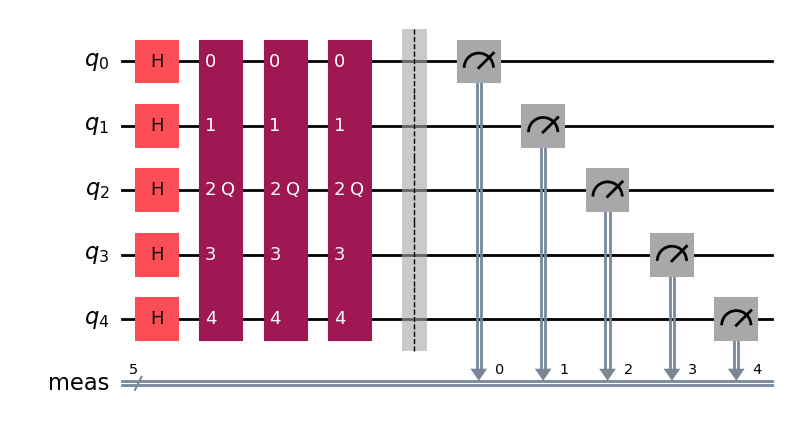

In [10]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

## Step 2. Optimize problem for quantum execution


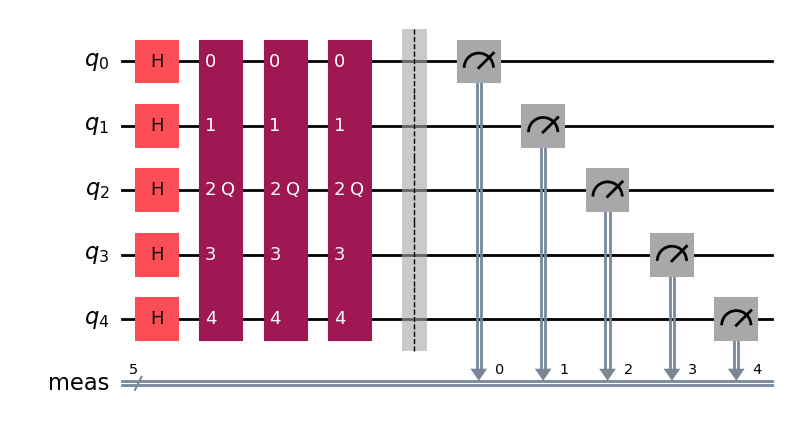

In [11]:
# No hardware-specific transpilation needed for local simulation.
# The StatevectorSampler accepts arbitrary circuits directly.
circuit_isa = qc
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

## Step 3. Execute using Qiskit Primitives

Amplitude amplification is a sampling problem that is suitable for execution with the [`Sampler`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.SamplerV2) runtime primitive.

Note that the `run()` method of [Qiskit Runtime `SamplerV2`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.SamplerV2)  takes an iterable of `primitive unified blocs (PUBs)`. For sampler, each PUB is an iterable in the format `(circuit, parameter_values)`. However, at a minimum, it takes a list of quantum circuit(s).


Setting Sampler

In [12]:
# Using local StatevectorSampler — runs on classical computer, no QPU needed
sampler = StatevectorSampler(seed=42)

Run

In [13]:
# Run locally — results are returned immediately (no queue)
result = sampler.run([circuit_isa], shots=10000).result()

Result

In [14]:
# Result was already obtained in the run cell above
result

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=10000, num_bits=5>)), metadata={'shots': 10000, 'circuit_metadata': {}})], metadata={'version': 2})

In [15]:
dist = result[0].data.meas.get_counts()
dist

{'11000': 4762,
 '01011': 4824,
 '00101': 13,
 '10000': 21,
 '11010': 15,
 '01010': 12,
 '10100': 17,
 '10011': 15,
 '01001': 14,
 '11101': 12,
 '11111': 19,
 '00100': 17,
 '10110': 14,
 '10010': 15,
 '11100': 12,
 '01000': 8,
 '01111': 10,
 '00011': 18,
 '11110': 13,
 '01101': 16,
 '11011': 12,
 '00001': 14,
 '00000': 15,
 '00111': 11,
 '10101': 18,
 '11001': 17,
 '01100': 10,
 '01110': 14,
 '10111': 14,
 '10001': 9,
 '00110': 10,
 '00010': 9}

In [16]:
# Full result object
result

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=10000, num_bits=5>)), metadata={'shots': 10000, 'circuit_metadata': {}})], metadata={'version': 2})

## Step 4. Post-process, return result in classical format


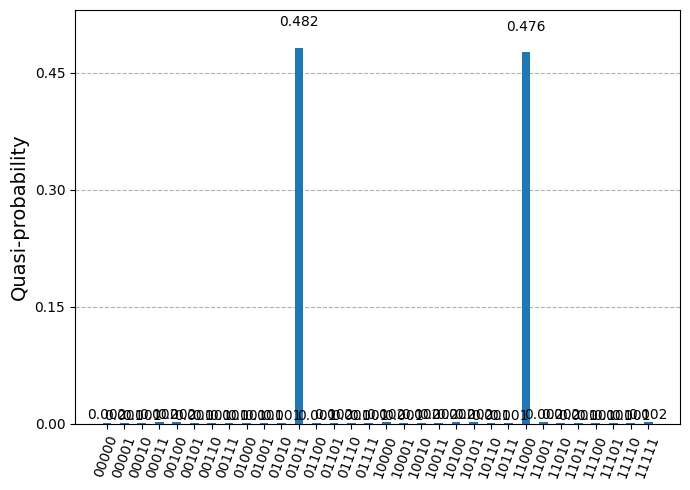

In [17]:
plot_distribution(dist)